In [1]:
!pip install tensorflow==2.5.0

In [2]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras import layers

2.5.0
2.5.0


In [3]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

11493376/11490434 [==============================] - 0s 0us/step


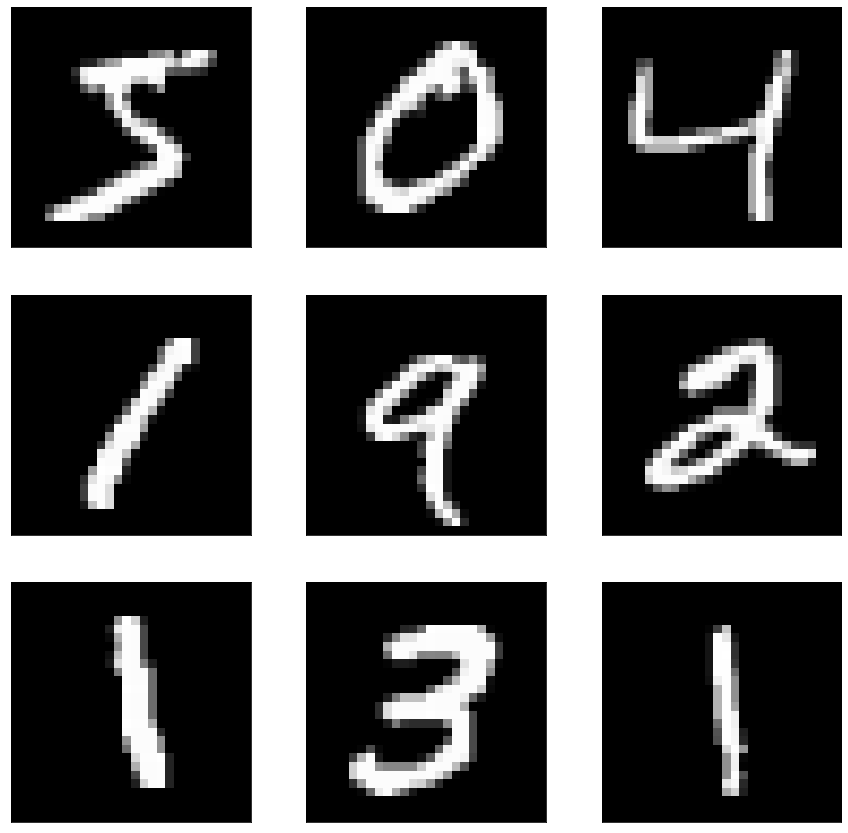

In [5]:
f, axs = plt.subplots(3,3, figsize=(15,15))
ix=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(x_train[ix].reshape(28,28), cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        ix+=1
plt.show()

# MLP with two hidden layers

In [10]:
#hyperparameters for the network
n_epoch = 100
n_hidden = 256
z_dim = 10
lr = 1e-4
patience=20
batch_size=100

In [11]:
#Defining the architecture

#Encoder
x = layers.Input(shape=(x_train.shape[1:]))
x_encoded = layers.Dense(n_hidden, activation='relu')(x)
x_encoded = layers.Dense(n_hidden//2, activation='relu')(x_encoded)
#Latent space
z = layers.Dense(z_dim)(x_encoded)
#Decoder
x_decoded = layers.Dense(n_hidden//2, activation='relu')(z)
x_decoded = layers.Dense(n_hidden, activation='relu')(x_decoded)
x_hat = layers.Dense(x_train.shape[1], activation='sigmoid')(x_decoded)

In [12]:
adam = keras.optimizers.Adam(lr=lr)
ae = keras.Model(x, x_hat)
ae.compile(optimizer=adam, loss='mean_squared_error')
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 784)               2014

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

history = ae.fit(x_train,x_train,
          shuffle=True,
          epochs=n_epoch,
          batch_size=batch_size,
          validation_data=(x_test, x_test), 
          callbacks= [early_stopping], 
          verbose=1)

Epoch 1/100
600/600 [==============================] - 8s 12ms/step - loss: 0.0735 - val_loss: 0.0440
Epoch 2/100
600/600 [==============================] - 7s 12ms/step - loss: 0.0385 - val_loss: 0.0342
Epoch 3/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0319 - val_loss: 0.0287
Epoch 4/100
600/600 [==============================] - 7s 12ms/step - loss: 0.0275 - val_loss: 0.0260
Epoch 5/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0256 - val_loss: 0.0246
Epoch 6/100
600/600 [==============================] - 7s 12ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 7/100
600/600 [==============================] - 7s 12ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 8/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0227 - val_loss: 0.0220
Epoch 9/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0221 - val_loss: 0.0215
Epoch 10/100
600/600 [==============================] - 7s 11ms/step - loss: 0.021

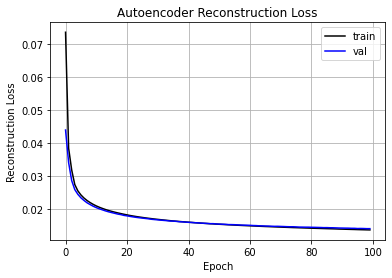

In [14]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

In [15]:
x_hat_test = ae.predict(x_test)

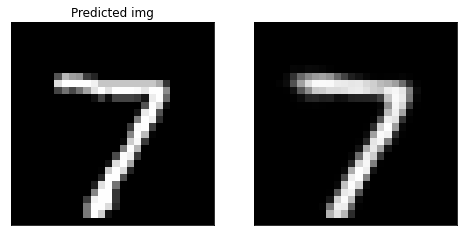

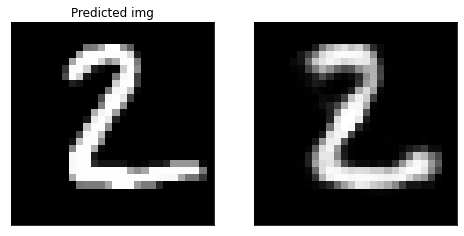

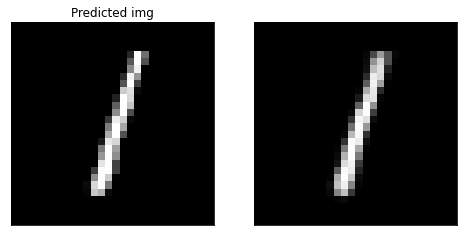

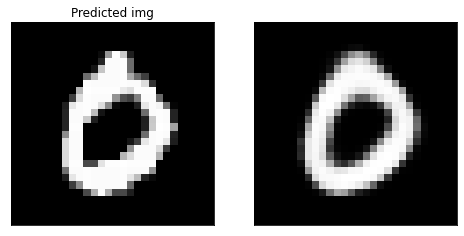

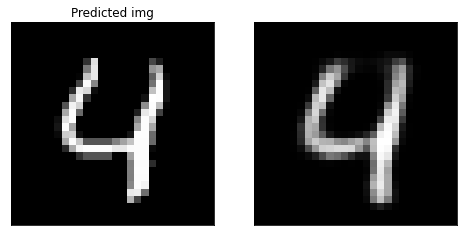

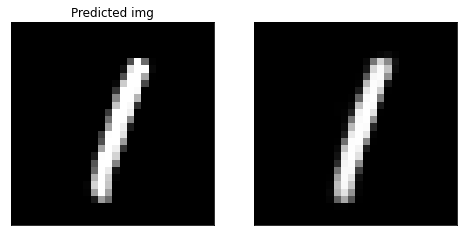

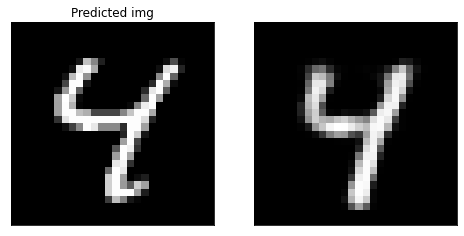

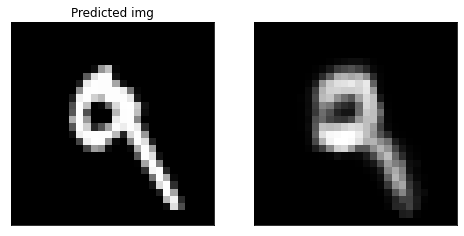

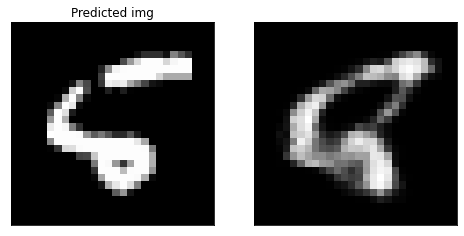

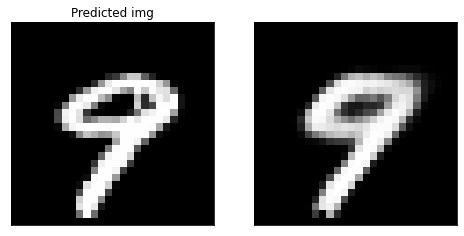

In [16]:
for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Predicted img')
    ax2.imshow(x_hat_test[i].reshape(28,28), cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [17]:
Encoder = keras.Model(x, z)
z_test = Encoder.predict(x_test)

In [18]:
#Dimensionality Reduction using t-SNE
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

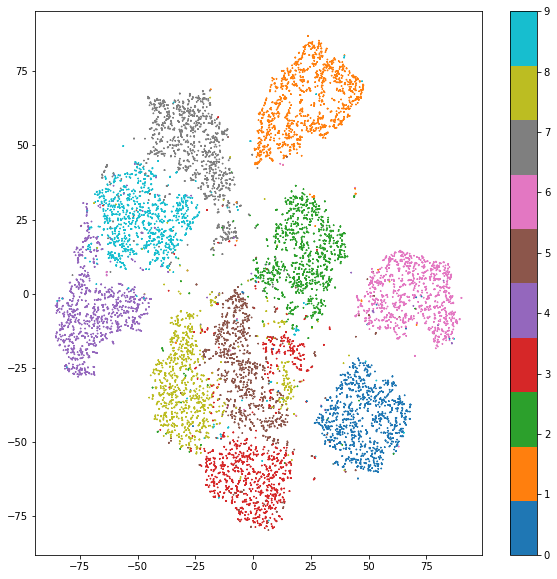

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()

# Deep Convolutional Autoencoder (DCAE)

In [20]:
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

In [21]:
import cv2

target_size = (32,32) #For the following architecture, we used 32x32 images.
x_train = np.array([cv2.resize(image, dsize=target_size) for image in x_train])
x_test = np.array([cv2.resize(image, dsize=target_size) for image in x_test])
conv_dim=64
z_dim = 10
batch_size = 64

In [22]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [23]:
# As this DCAE uses more GPU capacity, we have to use generators.
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
generator_train = datagen.flow(x_train, x_train, batch_size=batch_size, shuffle=True)
generator_test = datagen.flow(x_test, x_test, batch_size=batch_size, shuffle=False)

In [24]:
#Encoder
x = layers.Input(shape=(32,32,1))
x_encoded = layers.Conv2D(conv_dim, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x)
x_encoded = layers.Conv2D(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Conv2D(conv_dim*4, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Conv2D(conv_dim*8, kernel_size=4, strides=(1,1), padding='same', activation='relu')(x_encoded)
x_encoded = layers.Flatten()(x_encoded)
#Latent space
z = layers.Dense(z_dim)(x_encoded)
#Decoder
x_decoded = layers.Dense(4 * 4 * 512)(z)
x_decoded = layers.Reshape((4, 4, 512))(x_decoded)
x_decoded = layers.Conv2DTranspose(conv_dim*8, kernel_size=1, strides=(1,1), padding='same', activation='relu')(x_decoded)
x_decoded = layers.Conv2DTranspose(conv_dim*4, kernel_size=1, strides=(1,1), padding='same', activation='relu')(x_decoded)
x_decoded = layers.Conv2DTranspose(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_decoded)
x_decoded = layers.Conv2DTranspose(conv_dim*1, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_decoded)
x_hat = layers.Conv2DTranspose(1, kernel_size=4, strides=(2,2), padding='same', activation='sigmoid')(x_decoded)


In [25]:
lr=1e-5
patience=10
adam = keras.optimizers.Adam(lr=lr)
dcae = keras.Model(x, x_hat)
dcae.compile(optimizer=adam, loss='mean_squared_error')
dcae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         2097664   
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                8193

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')
n_epoch=10
history = dcae.fit_generator(generator_train,
          shuffle=True,
          epochs=n_epoch,
          validation_data=generator_test, 
          callbacks= [early_stopping],
          steps_per_epoch=x_train.shape[0]//batch_size,
          validation_steps=x_test.shape[0]//batch_size,
          verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
937/937 [==============================] - 1104s 1s/step - loss: 0.1093 - val_loss: 0.0576
Epoch 2/10
937/937 [==============================] - 1097s 1s/step - loss: 0.0517 - val_loss: 0.0485
Epoch 3/10
436/937 [============>.................] - ETA: 9:14 - loss: 0.0459

KeyboardInterrupt: ignored

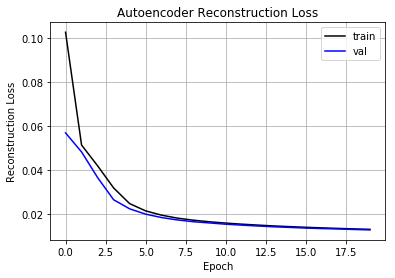

In [ ]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

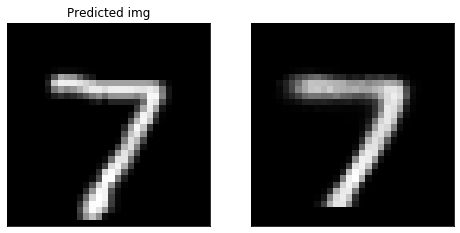

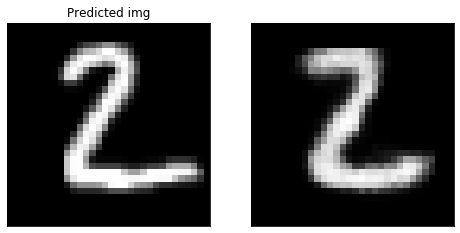

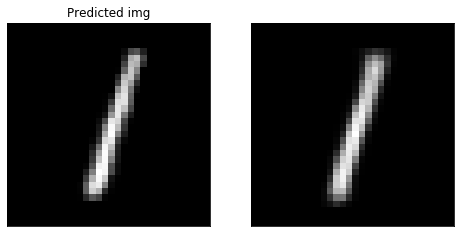

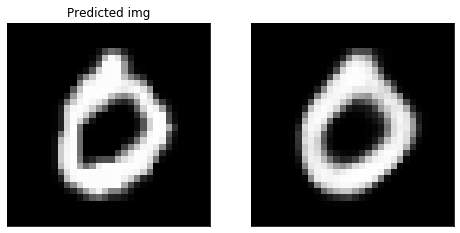

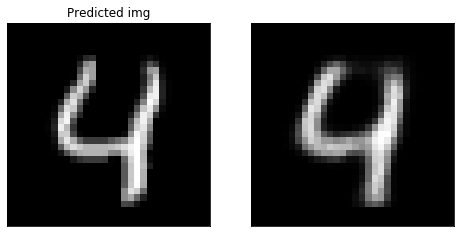

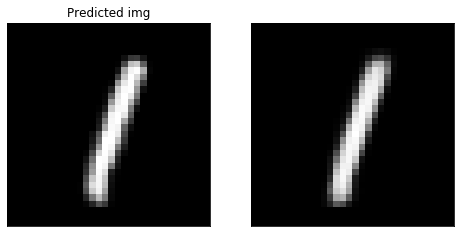

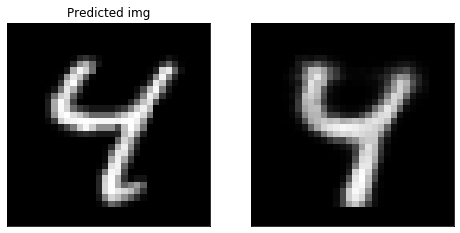

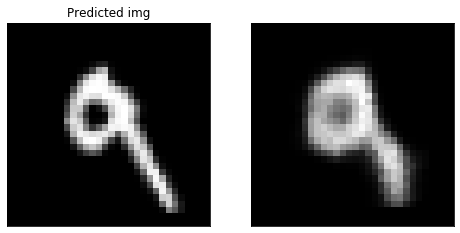

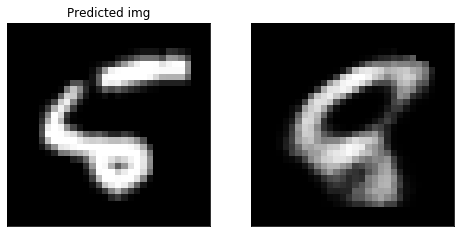

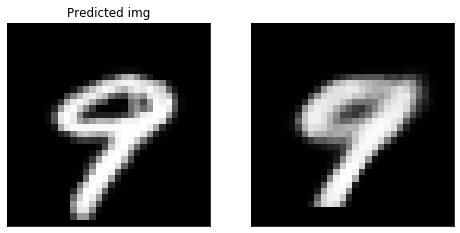

In [ ]:
x_hat_test = dcae.predict(x_test)

for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i, :, :, 0], cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Predicted img')
    ax2.imshow(x_hat_test[i, :, :, 0], cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [ ]:
Encoder = keras.Model(x, z)

z_test = Encoder.predict(x_test)
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

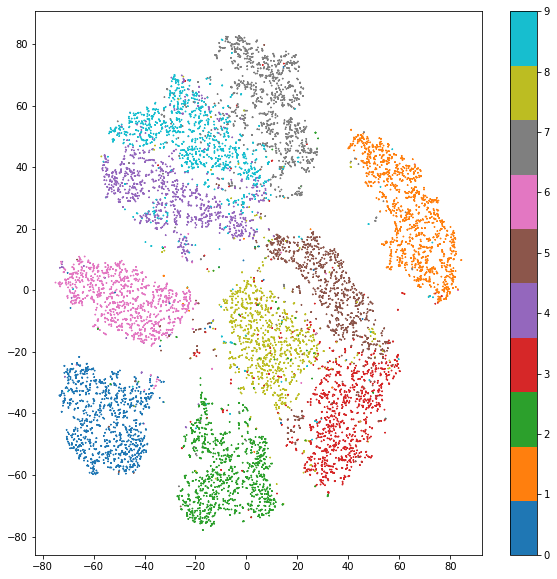

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()